In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer


from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import pad_sequences



import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
import json

from sklearn import feature_selection


2023-05-01 16:07:41.656438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:

with open("dataset_lemmatized/dataset_normalized_NLTK+TF1stopword.json", 'r') as f:
     dataset = json.load(f)

initial_dataset = pd.read_csv('IMDB Dataset.csv')

In [6]:

def get_train_val_test(dataset):

    train_fraction = 0.8
    df_train = dataset[:int(train_fraction*len(dataset))]
    df_val = dataset[int(train_fraction*len(dataset)):int((train_fraction + 0.1 )*len(dataset))]
    df_test = dataset[int((train_fraction+0.1)*len(dataset)):]

    print("Train shape: ", len(df_train))
    print("Val shape: ", len(df_val))
    print("Test shape: ", len(df_test))

    return df_train, df_val, df_test

df_train, df_val, df_test = get_train_val_test(dataset)

y_train, y_val, y_test = get_train_val_test(initial_dataset['sentiment'])

y_train = np.array(y_train.replace({'positive': 1, 'negative': 0}))
y_val = np.array(y_val.replace({'positive': 1, 'negative': 0}))
y_test = np.array(y_test.replace({'positive': 1, 'negative': 0}))


Train shape:  40000
Val shape:  5000
Test shape:  5000
Train shape:  40000
Val shape:  5000
Test shape:  5000


In [43]:
def get_features_tf_idf(df_train, df_val, df_test, X_names=None):

    vectorizer = TfidfVectorizer(
        analyzer = 'word', 
        tokenizer = lambda x:x, 
        preprocessor = lambda x:x,
        lowercase = False,
        strip_accents = 'ascii',
        min_df = 20, 
        vocabulary=X_names,
    )


    vectorizer.fit(df_train)
    feature_names = vectorizer.get_feature_names_out()

    X_train = vectorizer.transform(df_train).toarray()
    X_val = vectorizer.transform(df_val).toarray()
    X_test = vectorizer.transform(df_test).toarray()


    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)

    print(X_train)

    X_train = X_train.to_numpy()
    X_val = X_val.to_numpy()
    X_test = X_test.to_numpy()


    return X_train, X_val, X_test, vectorizer

X_train, X_val, X_test, vectorizer = get_features_tf_idf(df_train, df_val, df_test)

# store the vocabulary size, the number of documents and their length
vocab_size = len(vectorizer.vocabulary_)
documents_number = len(X_train)
documents_length = X_train.shape[1]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(vocab_size)
print(documents_number)
print(documents_length)

       aamir  aaron  abandon  abandonment  abbey  abbot  abbott  abc  abduct  \
0        0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
1        0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
2        0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
3        0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
4        0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
...      ...    ...      ...          ...    ...    ...     ...  ...     ...   
39995    0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
39996    0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
39997    0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
39998    0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   
39999    0.0    0.0      0.0          0.0    0.0    0.0     0.0  0.0     0.0   

       abduction  ...  zoe  zoey    zom

In [133]:
def get_most_relevant_features():
    y = y_train
    X_names = vectorizer.get_feature_names_out()
    p_value_limit = 0.95
    features_aux = pd.DataFrame()
    for value in np.unique(y):
        chi2, p = feature_selection.chi2(X_train, y==value)
        features_aux = features_aux.append(pd.DataFrame(
                    {"feature":X_names, "score":1-p, "y":value}))
        features_aux = features_aux.sort_values(["y","score"], 
                        ascending=[True,False])
        features_aux = features_aux[features_aux["score"]>p_value_limit]
    X_names = features_aux["feature"].unique().tolist()
    for value in np.unique(y):
        print("Category {}:".format(value))
        print("  - Number of relevant features",
                len(features_aux[features_aux["y"]==value]))
        print("  - Top relevant features:", ",".join(
        features_aux[features_aux["y"]==value]["feature"].values[:10]))
        print(" ")

    return X_names

X_names = get_most_relevant_features()

Category 0:
  - Number of relevant features 1206
  - Top relevant features: awful,bad,boring,crap,excellent,great,horrible,love,nothing,poor
 
Category 1:
  - Number of relevant features 1206
  - Top relevant features: awful,bad,boring,crap,excellent,great,horrible,love,nothing,poor
 


In [106]:
X_train, X_val, X_test, vectorizer = get_features_tf_idf(df_train, df_val, df_test, X_names=X_names)
vocab_size = len(vectorizer.vocabulary_)
documents_number = len(X_train)
documents_length = X_train.shape[1]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(vocab_size)
print(documents_number)
print(documents_length)

       awful     bad  boring  crap  excellent     great  horrible      love  \
0        0.0  0.0000     0.0   0.0   0.000000  0.000000       0.0  0.000000   
1        0.0  0.0000     0.0   0.0   0.000000  0.104669       0.0  0.000000   
2        0.0  0.0000     0.0   0.0   0.000000  0.129757       0.0  0.140935   
3        0.0  0.0000     0.0   0.0   0.000000  0.000000       0.0  0.000000   
4        0.0  0.0000     0.0   0.0   0.000000  0.000000       0.0  0.098142   
...      ...     ...     ...   ...        ...       ...       ...       ...   
39995    0.0  0.0000     0.0   0.0   0.000000  0.291532       0.0  0.105549   
39996    0.0  0.0000     0.0   0.0   0.000000  0.000000       0.0  0.000000   
39997    0.0  0.0000     0.0   0.0   0.139154  0.353074       0.0  0.095873   
39998    0.0  0.0000     0.0   0.0   0.000000  0.000000       0.0  0.096017   
39999    0.0  0.0668     0.0   0.0   0.000000  0.000000       0.0  0.076701   

       nothing  poor  ...  ultimate  rehash  barber

In [134]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128,input_shape = (documents_length,), activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.1), 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, 
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
              )

print(model.summary())

history = model.fit(X_train, y_train,
    epochs = 10, 
    batch_size = 512, 
    initial_epoch = 0, 
    verbose=1,
    shuffle=True,
    validation_data=(X_val, y_val))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=512)
print('Test score:', score)
print('Test accuracy:', acc)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 128)               155136    
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 1)                 33        
                                                                 
Total params: 165,505
Trainable params: 165,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
79/79 [========================

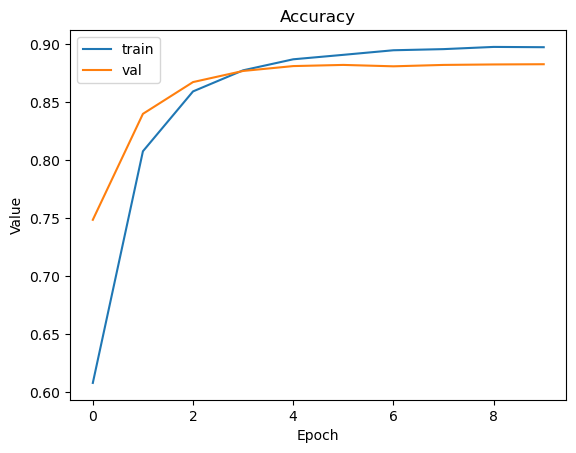

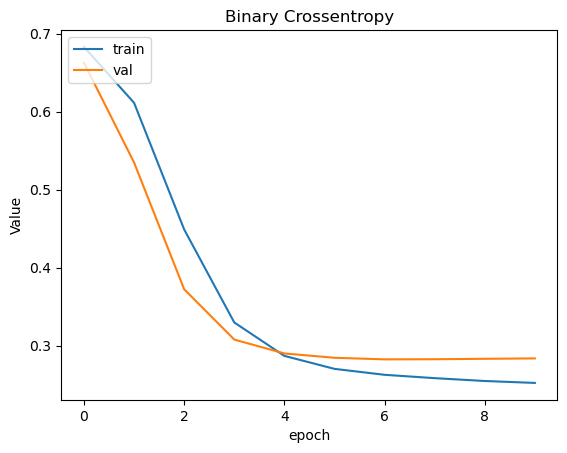

In [135]:

def make_plots():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Accuracy')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Binary Crossentropy')
    plt.ylabel('Value')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

make_plots()

In [136]:
# predict the target for the test set and format it according to the given standards
y_test_predicted = np.round(model.predict(X_test, verbose = 1))
y_test_predicted = pd.DataFrame(y_test_predicted)
y_test_output = pd.concat([y_test_predicted, pd.Series(y_test)], axis=1)
y_test_output.columns = ["prediction", 'ground_truth']
print(y_test_output)

y_test_predicted = y_test_predicted.round() # print the classification report

print(classification_report(y_test, y_test_predicted))


157/157 [==============================] - 0s 1ms/step
      prediction  ground_truth
0            1.0             1
1            1.0             1
2            0.0             0
3            0.0             0
4            0.0             0
...          ...           ...
4995         1.0             1
4996         0.0             0
4997         1.0             0
4998         0.0             0
4999         0.0             0

[5000 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2530
           1       0.88      0.88      0.88      2470

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [50]:

with open("dataset_lemmatized/dataset_normalized_NLTK+TF1stopword.json", 'r') as f:
     dataset = json.load(f)

In [52]:
import collections
word_counter = collections.Counter()
for review in dataset:
    for term in review:
        word_counter.update({term: 1})



In [78]:

vocab = [t for t in word_counter if t in X_names]
vocab.append('UNKNOWN')
Idx = range(1, len(vocab)+1)
Word2Idx = dict(zip(vocab, Idx))
Idx2Word = dict(zip(Idx, vocab))

In [80]:
dataset_embedded = []
for review in dataset:
    review_embedded = []
    for term in review:
        if term in Word2Idx:
            review_embedded.append(Word2Idx[term])
        else:
            review_embedded.append(Word2Idx['UNKNOWN'])
    dataset_embedded.append(review_embedded)
    

In [81]:
x_train, x_val, x_test = get_train_val_test(dataset_embedded)
y_train, y_val, y_test = get_train_val_test(initial_dataset['sentiment'])

y_train = np.array(y_train.replace({'positive': 1, 'negative': 0}))
y_val = np.array(y_val.replace({'positive': 1, 'negative': 0}))
y_test = np.array(y_test.replace({'positive': 1, 'negative': 0}))

Train shape:  40000
Val shape:  5000
Test shape:  5000
Train shape:  40000
Val shape:  5000
Test shape:  5000


In [84]:
maxlen = 80 
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

x_train shape: (40000, 80)
x_val shape: (5000, 80)
x_test shape: (5000, 80)


In [138]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vocab) + 1, 64),
    tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          shuffle=True,
          validation_data=(x_val, y_val))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=256)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/5
157/157 [==============================] - 58s 314ms/step - loss: 0.6840 - accuracy: 0.5653 - val_loss: 0.5884 - val_accuracy: 0.7376
Epoch 2/5
157/157 [==============================] - 51s 328ms/step - loss: 0.5132 - accuracy: 0.7672 - val_loss: 0.4422 - val_accuracy: 0.8168
Epoch 3/5
157/157 [==============================] - 51s 326ms/step - loss: 0.3642 - accuracy: 0.8445 - val_loss: 0.3407 - val_accuracy: 0.8554
Epoch 4/5
157/157 [==============================] - 49s 312ms/step - loss: 0.3296 - accuracy: 0.8619 - val_loss: 0.3226 - val_accuracy: 0.8648
Epoch 5/5
20/20 [==============================] - 1s 55ms/step - loss: 0.3255 - accuracy: 0.8652
Test score: 0.3254798352718353
Test accuracy: 0.8651999831199646


In [139]:
y_test_predicted = np.round(model.predict(x_test, verbose = 1))
y_test_predicted = pd.DataFrame(y_test_predicted)
y_test_output = pd.concat([y_test_predicted, pd.Series(y_test)], axis=1)
y_test_output.columns = ["prediction", 'ground_truth']
print(y_test_output)

y_test_predicted = y_test_predicted.round() # print the classification report

print(classification_report(y_test, y_test_predicted))

157/157 [==============================] - 2s 12ms/step
      prediction  ground_truth
0            1.0             1
1            1.0             1
2            0.0             0
3            0.0             0
4            0.0             0
...          ...           ...
4995         1.0             1
4996         0.0             0
4997         1.0             0
4998         0.0             0
4999         0.0             0

[5000 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2530
           1       0.84      0.89      0.87      2470

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



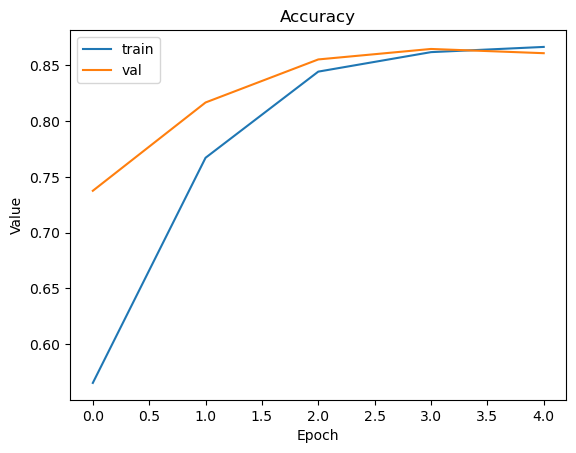

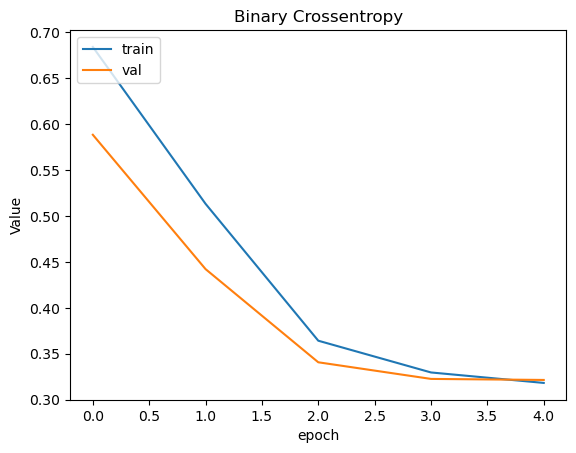

In [140]:
make_plots()